In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from rl_introduction.tools import Agent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train
env = gym.make('FrozenLake-v0')

In [2]:
class MyRandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def act(self, state):
        action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}



[
$\frac{\sum_{i=1}^n \mathbb{1}[S_i = s] G_i}{\sum_{i=1}^n \mathbb{1}[S_i = s]} $
is convergent if $G_{s_i}$ is Independent and identically distributed.
]


remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N(S_t)}(G_t -V(S_t))\\
\end{aligned}

In [3]:
# TODO import functions
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V

def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy



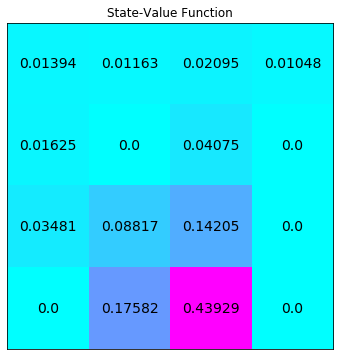

In [4]:
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy)
plot_values_lake(V)

In [5]:
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n)
    count_states = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        count_states_by_update = np.zeros(env.observation_space.n)
        
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            count_states[current_state] += 1
            count_states_by_update[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(count_states):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - count_states_by_update[state] * V[state]) / count
    return V

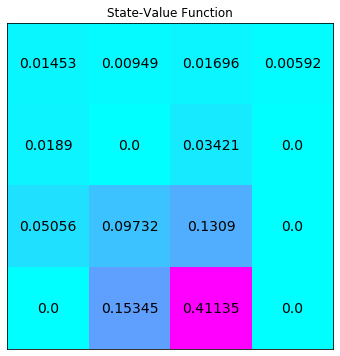

In [6]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

In [7]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

#TODO
explain exploration

In the same way, we estimate the Q function. Ans we build an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

In [8]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, baseline = 1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) * baseline
        #self.q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True:
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)):
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 :
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n):
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 380 - cum reward 0.0
episode: 381 - cum reward 0.0
episode: 382 - cum reward 0.0
episode: 383 - cum reward 0.0
episode: 384 - cum reward 0.0
episode: 385 - cum reward 0.0
episode: 386 - cum reward 0.0
episode: 387 - cum reward 0.0
episode: 388 - cum reward 0.0
episode: 389 - cum reward 0.0
episode: 390 - cum reward 0.0
episode: 391 - cum reward 0.0
episode: 392 - cum reward 0.0
episode: 393 - cum reward 0.0
episode: 394 - cum reward 0.0
episode: 395 - cum reward 0.0
episode: 396 - cum reward 0.0
episode: 397 - cum reward 0.0
episode: 398 - cum reward 0.0
episode: 399 - cum reward 0.0
episode: 400 - cum reward 0.0
episode: 401 - cum reward 0.0
episode: 402 - cum reward 0.0
episode: 403 - cum reward 0.0
episode: 404 - cum reward 0.0
episode: 405 - cum reward 0.0
episode: 406 - cum reward 0.0
episode: 407 - cum reward 0.0
episode: 408 - cum reward 0.0
episode: 409 - cum reward 0.0
episode: 410 - cum reward 0.0
episode: 411 - cum reward 0.0
episode: 412 - cum reward 0.0
episode: 4

episode: 728 - cum reward 0.0
episode: 729 - cum reward 0.0
episode: 730 - cum reward 0.0
episode: 731 - cum reward 0.0
episode: 732 - cum reward 0.0
episode: 733 - cum reward 0.0
episode: 734 - cum reward 0.0
episode: 735 - cum reward 0.0
episode: 736 - cum reward 0.0
episode: 737 - cum reward 0.0
episode: 738 - cum reward 0.0
episode: 739 - cum reward 0.0
episode: 740 - cum reward 1.0
episode: 741 - cum reward 0.0
episode: 742 - cum reward 0.0
episode: 743 - cum reward 0.0
episode: 744 - cum reward 0.0
episode: 745 - cum reward 0.0
episode: 746 - cum reward 0.0
episode: 747 - cum reward 1.0
episode: 748 - cum reward 0.0
episode: 749 - cum reward 0.0
episode: 750 - cum reward 0.0
episode: 751 - cum reward 0.0
episode: 752 - cum reward 0.0
episode: 753 - cum reward 0.0
episode: 754 - cum reward 0.0
episode: 755 - cum reward 0.0
episode: 756 - cum reward 0.0
episode: 757 - cum reward 1.0
episode: 758 - cum reward 0.0
episode: 759 - cum reward 0.0
episode: 760 - cum reward 0.0
episode: 7

episode: 1058 - cum reward 0.0
episode: 1059 - cum reward 0.0
episode: 1060 - cum reward 0.0
episode: 1061 - cum reward 0.0
episode: 1062 - cum reward 0.0
episode: 1063 - cum reward 0.0
episode: 1064 - cum reward 0.0
episode: 1065 - cum reward 0.0
episode: 1066 - cum reward 0.0
episode: 1067 - cum reward 0.0
episode: 1068 - cum reward 0.0
episode: 1069 - cum reward 1.0
episode: 1070 - cum reward 0.0
episode: 1071 - cum reward 0.0
episode: 1072 - cum reward 0.0
episode: 1073 - cum reward 0.0
episode: 1074 - cum reward 0.0
episode: 1075 - cum reward 0.0
episode: 1076 - cum reward 0.0
episode: 1077 - cum reward 0.0
episode: 1078 - cum reward 1.0
episode: 1079 - cum reward 0.0
episode: 1080 - cum reward 0.0
episode: 1081 - cum reward 0.0
episode: 1082 - cum reward 0.0
episode: 1083 - cum reward 0.0
episode: 1084 - cum reward 0.0
episode: 1085 - cum reward 0.0
episode: 1086 - cum reward 0.0
episode: 1087 - cum reward 0.0
episode: 1088 - cum reward 0.0
episode: 1089 - cum reward 0.0
episode:

episode: 1376 - cum reward 0.0
episode: 1377 - cum reward 0.0
episode: 1378 - cum reward 1.0
episode: 1379 - cum reward 0.0
episode: 1380 - cum reward 0.0
episode: 1381 - cum reward 0.0
episode: 1382 - cum reward 0.0
episode: 1383 - cum reward 0.0
episode: 1384 - cum reward 0.0
episode: 1385 - cum reward 0.0
episode: 1386 - cum reward 0.0
episode: 1387 - cum reward 0.0
episode: 1388 - cum reward 0.0
episode: 1389 - cum reward 0.0
episode: 1390 - cum reward 0.0
episode: 1391 - cum reward 0.0
episode: 1392 - cum reward 0.0
episode: 1393 - cum reward 0.0
episode: 1394 - cum reward 0.0
episode: 1395 - cum reward 1.0
episode: 1396 - cum reward 0.0
episode: 1397 - cum reward 0.0
episode: 1398 - cum reward 1.0
episode: 1399 - cum reward 0.0
episode: 1400 - cum reward 0.0
episode: 1401 - cum reward 0.0
episode: 1402 - cum reward 0.0
episode: 1403 - cum reward 0.0
episode: 1404 - cum reward 0.0
episode: 1405 - cum reward 0.0
episode: 1406 - cum reward 0.0
episode: 1407 - cum reward 0.0
episode:

episode: 1691 - cum reward 0.0
episode: 1692 - cum reward 0.0
episode: 1693 - cum reward 0.0
episode: 1694 - cum reward 0.0
episode: 1695 - cum reward 1.0
episode: 1696 - cum reward 0.0
episode: 1697 - cum reward 0.0
episode: 1698 - cum reward 0.0
episode: 1699 - cum reward 1.0
episode: 1700 - cum reward 0.0
episode: 1701 - cum reward 0.0
episode: 1702 - cum reward 0.0
episode: 1703 - cum reward 0.0
episode: 1704 - cum reward 1.0
episode: 1705 - cum reward 0.0
episode: 1706 - cum reward 0.0
episode: 1707 - cum reward 1.0
episode: 1708 - cum reward 0.0
episode: 1709 - cum reward 0.0
episode: 1710 - cum reward 0.0
episode: 1711 - cum reward 0.0
episode: 1712 - cum reward 0.0
episode: 1713 - cum reward 0.0
episode: 1714 - cum reward 0.0
episode: 1715 - cum reward 0.0
episode: 1716 - cum reward 0.0
episode: 1717 - cum reward 0.0
episode: 1718 - cum reward 0.0
episode: 1719 - cum reward 0.0
episode: 1720 - cum reward 0.0
episode: 1721 - cum reward 0.0
episode: 1722 - cum reward 0.0
episode:

episode: 2010 - cum reward 0.0
episode: 2011 - cum reward 0.0
episode: 2012 - cum reward 0.0
episode: 2013 - cum reward 1.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 0.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 0.0
episode: 2019 - cum reward 0.0
episode: 2020 - cum reward 0.0
episode: 2021 - cum reward 0.0
episode: 2022 - cum reward 0.0
episode: 2023 - cum reward 0.0
episode: 2024 - cum reward 0.0
episode: 2025 - cum reward 0.0
episode: 2026 - cum reward 1.0
episode: 2027 - cum reward 0.0
episode: 2028 - cum reward 0.0
episode: 2029 - cum reward 0.0
episode: 2030 - cum reward 0.0
episode: 2031 - cum reward 0.0
episode: 2032 - cum reward 0.0
episode: 2033 - cum reward 0.0
episode: 2034 - cum reward 1.0
episode: 2035 - cum reward 0.0
episode: 2036 - cum reward 1.0
episode: 2037 - cum reward 0.0
episode: 2038 - cum reward 0.0
episode: 2039 - cum reward 0.0
episode: 2040 - cum reward 0.0
episode: 2041 - cum reward 0.0
episode:

episode: 2329 - cum reward 0.0
episode: 2330 - cum reward 0.0
episode: 2331 - cum reward 0.0
episode: 2332 - cum reward 0.0
episode: 2333 - cum reward 0.0
episode: 2334 - cum reward 0.0
episode: 2335 - cum reward 0.0
episode: 2336 - cum reward 1.0
episode: 2337 - cum reward 0.0
episode: 2338 - cum reward 0.0
episode: 2339 - cum reward 0.0
episode: 2340 - cum reward 1.0
episode: 2341 - cum reward 0.0
episode: 2342 - cum reward 1.0
episode: 2343 - cum reward 0.0
episode: 2344 - cum reward 0.0
episode: 2345 - cum reward 0.0
episode: 2346 - cum reward 0.0
episode: 2347 - cum reward 0.0
episode: 2348 - cum reward 0.0
episode: 2349 - cum reward 0.0
episode: 2350 - cum reward 0.0
episode: 2351 - cum reward 0.0
episode: 2352 - cum reward 0.0
episode: 2353 - cum reward 1.0
episode: 2354 - cum reward 0.0
episode: 2355 - cum reward 0.0
episode: 2356 - cum reward 0.0
episode: 2357 - cum reward 1.0
episode: 2358 - cum reward 0.0
episode: 2359 - cum reward 0.0
episode: 2360 - cum reward 0.0
episode:

episode: 2636 - cum reward 0.0
episode: 2637 - cum reward 0.0
episode: 2638 - cum reward 0.0
episode: 2639 - cum reward 1.0
episode: 2640 - cum reward 0.0
episode: 2641 - cum reward 0.0
episode: 2642 - cum reward 1.0
episode: 2643 - cum reward 0.0
episode: 2644 - cum reward 0.0
episode: 2645 - cum reward 1.0
episode: 2646 - cum reward 0.0
episode: 2647 - cum reward 1.0
episode: 2648 - cum reward 0.0
episode: 2649 - cum reward 0.0
episode: 2650 - cum reward 0.0
episode: 2651 - cum reward 1.0
episode: 2652 - cum reward 0.0
episode: 2653 - cum reward 0.0
episode: 2654 - cum reward 1.0
episode: 2655 - cum reward 0.0
episode: 2656 - cum reward 0.0
episode: 2657 - cum reward 0.0
episode: 2658 - cum reward 1.0
episode: 2659 - cum reward 0.0
episode: 2660 - cum reward 0.0
episode: 2661 - cum reward 1.0
episode: 2662 - cum reward 1.0
episode: 2663 - cum reward 0.0
episode: 2664 - cum reward 0.0
episode: 2665 - cum reward 0.0
episode: 2666 - cum reward 0.0
episode: 2667 - cum reward 0.0
episode:

episode: 2914 - cum reward 0.0
episode: 2915 - cum reward 0.0
episode: 2916 - cum reward 0.0
episode: 2917 - cum reward 0.0
episode: 2918 - cum reward 0.0
episode: 2919 - cum reward 0.0
episode: 2920 - cum reward 0.0
episode: 2921 - cum reward 0.0
episode: 2922 - cum reward 0.0
episode: 2923 - cum reward 0.0
episode: 2924 - cum reward 0.0
episode: 2925 - cum reward 0.0
episode: 2926 - cum reward 0.0
episode: 2927 - cum reward 0.0
episode: 2928 - cum reward 0.0
episode: 2929 - cum reward 0.0
episode: 2930 - cum reward 0.0
episode: 2931 - cum reward 0.0
episode: 2932 - cum reward 0.0
episode: 2933 - cum reward 0.0
episode: 2934 - cum reward 0.0
episode: 2935 - cum reward 0.0
episode: 2936 - cum reward 0.0
episode: 2937 - cum reward 0.0
episode: 2938 - cum reward 0.0
episode: 2939 - cum reward 0.0
episode: 2940 - cum reward 0.0
episode: 2941 - cum reward 1.0
episode: 2942 - cum reward 0.0
episode: 2943 - cum reward 0.0
episode: 2944 - cum reward 0.0
episode: 2945 - cum reward 0.0
episode:

episode: 3213 - cum reward 0.0
episode: 3214 - cum reward 0.0
episode: 3215 - cum reward 0.0
episode: 3216 - cum reward 0.0
episode: 3217 - cum reward 0.0
episode: 3218 - cum reward 1.0
episode: 3219 - cum reward 0.0
episode: 3220 - cum reward 0.0
episode: 3221 - cum reward 0.0
episode: 3222 - cum reward 0.0
episode: 3223 - cum reward 0.0
episode: 3224 - cum reward 0.0
episode: 3225 - cum reward 0.0
episode: 3226 - cum reward 0.0
episode: 3227 - cum reward 0.0
episode: 3228 - cum reward 0.0
episode: 3229 - cum reward 0.0
episode: 3230 - cum reward 0.0
episode: 3231 - cum reward 0.0
episode: 3232 - cum reward 0.0
episode: 3233 - cum reward 1.0
episode: 3234 - cum reward 1.0
episode: 3235 - cum reward 0.0
episode: 3236 - cum reward 1.0
episode: 3237 - cum reward 0.0
episode: 3238 - cum reward 0.0
episode: 3239 - cum reward 0.0
episode: 3240 - cum reward 1.0
episode: 3241 - cum reward 0.0
episode: 3242 - cum reward 0.0
episode: 3243 - cum reward 0.0
episode: 3244 - cum reward 0.0
episode:

episode: 3502 - cum reward 1.0
episode: 3503 - cum reward 0.0
episode: 3504 - cum reward 0.0
episode: 3505 - cum reward 0.0
episode: 3506 - cum reward 0.0
episode: 3507 - cum reward 0.0
episode: 3508 - cum reward 0.0
episode: 3509 - cum reward 1.0
episode: 3510 - cum reward 1.0
episode: 3511 - cum reward 1.0
episode: 3512 - cum reward 0.0
episode: 3513 - cum reward 0.0
episode: 3514 - cum reward 0.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode: 3517 - cum reward 1.0
episode: 3518 - cum reward 1.0
episode: 3519 - cum reward 0.0
episode: 3520 - cum reward 0.0
episode: 3521 - cum reward 1.0
episode: 3522 - cum reward 0.0
episode: 3523 - cum reward 1.0
episode: 3524 - cum reward 0.0
episode: 3525 - cum reward 0.0
episode: 3526 - cum reward 0.0
episode: 3527 - cum reward 0.0
episode: 3528 - cum reward 0.0
episode: 3529 - cum reward 0.0
episode: 3530 - cum reward 0.0
episode: 3531 - cum reward 0.0
episode: 3532 - cum reward 1.0
episode: 3533 - cum reward 0.0
episode:

episode: 3782 - cum reward 1.0
episode: 3783 - cum reward 0.0
episode: 3784 - cum reward 0.0
episode: 3785 - cum reward 0.0
episode: 3786 - cum reward 0.0
episode: 3787 - cum reward 1.0
episode: 3788 - cum reward 0.0
episode: 3789 - cum reward 0.0
episode: 3790 - cum reward 0.0
episode: 3791 - cum reward 0.0
episode: 3792 - cum reward 0.0
episode: 3793 - cum reward 0.0
episode: 3794 - cum reward 0.0
episode: 3795 - cum reward 1.0
episode: 3796 - cum reward 1.0
episode: 3797 - cum reward 0.0
episode: 3798 - cum reward 1.0
episode: 3799 - cum reward 0.0
episode: 3800 - cum reward 1.0
episode: 3801 - cum reward 0.0
episode: 3802 - cum reward 0.0
episode: 3803 - cum reward 1.0
episode: 3804 - cum reward 1.0
episode: 3805 - cum reward 1.0
episode: 3806 - cum reward 0.0
episode: 3807 - cum reward 0.0
episode: 3808 - cum reward 0.0
episode: 3809 - cum reward 0.0
episode: 3810 - cum reward 0.0
episode: 3811 - cum reward 0.0
episode: 3812 - cum reward 0.0
episode: 3813 - cum reward 0.0
episode:

episode: 4047 - cum reward 0.0
episode: 4048 - cum reward 0.0
episode: 4049 - cum reward 0.0
episode: 4050 - cum reward 0.0
episode: 4051 - cum reward 0.0
episode: 4052 - cum reward 0.0
episode: 4053 - cum reward 0.0
episode: 4054 - cum reward 1.0
episode: 4055 - cum reward 1.0
episode: 4056 - cum reward 0.0
episode: 4057 - cum reward 1.0
episode: 4058 - cum reward 0.0
episode: 4059 - cum reward 0.0
episode: 4060 - cum reward 1.0
episode: 4061 - cum reward 0.0
episode: 4062 - cum reward 1.0
episode: 4063 - cum reward 0.0
episode: 4064 - cum reward 1.0
episode: 4065 - cum reward 0.0
episode: 4066 - cum reward 0.0
episode: 4067 - cum reward 0.0
episode: 4068 - cum reward 0.0
episode: 4069 - cum reward 0.0
episode: 4070 - cum reward 0.0
episode: 4071 - cum reward 0.0
episode: 4072 - cum reward 0.0
episode: 4073 - cum reward 0.0
episode: 4074 - cum reward 1.0
episode: 4075 - cum reward 0.0
episode: 4076 - cum reward 0.0
episode: 4077 - cum reward 1.0
episode: 4078 - cum reward 0.0
episode:

episode: 4315 - cum reward 0.0
episode: 4316 - cum reward 0.0
episode: 4317 - cum reward 0.0
episode: 4318 - cum reward 0.0
episode: 4319 - cum reward 0.0
episode: 4320 - cum reward 0.0
episode: 4321 - cum reward 0.0
episode: 4322 - cum reward 0.0
episode: 4323 - cum reward 1.0
episode: 4324 - cum reward 1.0
episode: 4325 - cum reward 1.0
episode: 4326 - cum reward 0.0
episode: 4327 - cum reward 1.0
episode: 4328 - cum reward 1.0
episode: 4329 - cum reward 0.0
episode: 4330 - cum reward 0.0
episode: 4331 - cum reward 0.0
episode: 4332 - cum reward 1.0
episode: 4333 - cum reward 0.0
episode: 4334 - cum reward 0.0
episode: 4335 - cum reward 0.0
episode: 4336 - cum reward 0.0
episode: 4337 - cum reward 0.0
episode: 4338 - cum reward 0.0
episode: 4339 - cum reward 0.0
episode: 4340 - cum reward 1.0
episode: 4341 - cum reward 1.0
episode: 4342 - cum reward 1.0
episode: 4343 - cum reward 1.0
episode: 4344 - cum reward 0.0
episode: 4345 - cum reward 0.0
episode: 4346 - cum reward 0.0
episode:

episode: 4661 - cum reward 0.0
episode: 4662 - cum reward 1.0
episode: 4663 - cum reward 0.0
episode: 4664 - cum reward 0.0
episode: 4665 - cum reward 1.0
episode: 4666 - cum reward 0.0
episode: 4667 - cum reward 0.0
episode: 4668 - cum reward 0.0
episode: 4669 - cum reward 1.0
episode: 4670 - cum reward 0.0
episode: 4671 - cum reward 0.0
episode: 4672 - cum reward 0.0
episode: 4673 - cum reward 0.0
episode: 4674 - cum reward 0.0
episode: 4675 - cum reward 0.0
episode: 4676 - cum reward 0.0
episode: 4677 - cum reward 0.0
episode: 4678 - cum reward 1.0
episode: 4679 - cum reward 0.0
episode: 4680 - cum reward 1.0
episode: 4681 - cum reward 0.0
episode: 4682 - cum reward 0.0
episode: 4683 - cum reward 0.0
episode: 4684 - cum reward 0.0
episode: 4685 - cum reward 1.0
episode: 4686 - cum reward 1.0
episode: 4687 - cum reward 0.0
episode: 4688 - cum reward 1.0
episode: 4689 - cum reward 0.0
episode: 4690 - cum reward 0.0
episode: 4691 - cum reward 1.0
episode: 4692 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

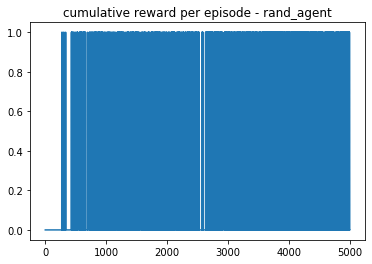

In [9]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [10]:
mc_agent.policy

array([[0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

In [11]:
V = policy_evaluation(env, mc_agent.policy)

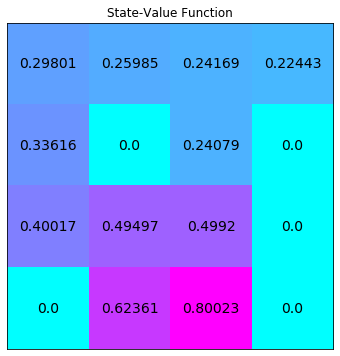

In [12]:
plot_values_lake(V)

In [13]:
V.sum()

4.419110494865578

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
We also know (bellman equation) $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$. That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [14]:
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    count_states = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        
        
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha# count_states[current_state]
    return V

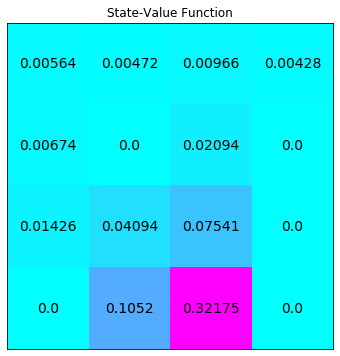

In [15]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [16]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 1.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 345 - cum reward 0.0
episode: 346 - cum reward 0.0
episode: 347 - cum reward 0.0
episode: 348 - cum reward 0.0
episode: 349 - cum reward 0.0
episode: 350 - cum reward 0.0
episode: 351 - cum reward 0.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 0.0
episode: 354 - cum reward 0.0
episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 373 - cum reward 0.0
episode: 374 - cum reward 0.0
episode: 375 - cum reward 0.0
episode: 376 - cum reward 0.0
episode: 377 - cum reward 0.0
episode: 3

episode: 702 - cum reward 0.0
episode: 703 - cum reward 0.0
episode: 704 - cum reward 0.0
episode: 705 - cum reward 0.0
episode: 706 - cum reward 0.0
episode: 707 - cum reward 0.0
episode: 708 - cum reward 0.0
episode: 709 - cum reward 0.0
episode: 710 - cum reward 0.0
episode: 711 - cum reward 0.0
episode: 712 - cum reward 0.0
episode: 713 - cum reward 0.0
episode: 714 - cum reward 1.0
episode: 715 - cum reward 0.0
episode: 716 - cum reward 0.0
episode: 717 - cum reward 0.0
episode: 718 - cum reward 0.0
episode: 719 - cum reward 0.0
episode: 720 - cum reward 0.0
episode: 721 - cum reward 0.0
episode: 722 - cum reward 0.0
episode: 723 - cum reward 0.0
episode: 724 - cum reward 0.0
episode: 725 - cum reward 0.0
episode: 726 - cum reward 0.0
episode: 727 - cum reward 0.0
episode: 728 - cum reward 0.0
episode: 729 - cum reward 0.0
episode: 730 - cum reward 0.0
episode: 731 - cum reward 0.0
episode: 732 - cum reward 1.0
episode: 733 - cum reward 0.0
episode: 734 - cum reward 0.0
episode: 7

episode: 979 - cum reward 0.0
episode: 980 - cum reward 0.0
episode: 981 - cum reward 0.0
episode: 982 - cum reward 0.0
episode: 983 - cum reward 0.0
episode: 984 - cum reward 0.0
episode: 985 - cum reward 0.0
episode: 986 - cum reward 0.0
episode: 987 - cum reward 0.0
episode: 988 - cum reward 0.0
episode: 989 - cum reward 0.0
episode: 990 - cum reward 0.0
episode: 991 - cum reward 0.0
episode: 992 - cum reward 0.0
episode: 993 - cum reward 0.0
episode: 994 - cum reward 0.0
episode: 995 - cum reward 0.0
episode: 996 - cum reward 0.0
episode: 997 - cum reward 0.0
episode: 998 - cum reward 0.0
episode: 999 - cum reward 1.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 0.0
episode: 1004 - cum reward 0.0
episode: 1005 - cum reward 0.0
episode: 1006 - cum reward 0.0
episode: 1007 - cum reward 0.0
episode: 1008 - cum reward 0.0
episode: 1009 - cum reward 0.0
episode: 1010 - cum reward 0.0
episode: 1011 - cum reward 0.

episode: 1247 - cum reward 0.0
episode: 1248 - cum reward 0.0
episode: 1249 - cum reward 0.0
episode: 1250 - cum reward 0.0
episode: 1251 - cum reward 0.0
episode: 1252 - cum reward 0.0
episode: 1253 - cum reward 0.0
episode: 1254 - cum reward 0.0
episode: 1255 - cum reward 0.0
episode: 1256 - cum reward 0.0
episode: 1257 - cum reward 0.0
episode: 1258 - cum reward 0.0
episode: 1259 - cum reward 0.0
episode: 1260 - cum reward 0.0
episode: 1261 - cum reward 0.0
episode: 1262 - cum reward 0.0
episode: 1263 - cum reward 0.0
episode: 1264 - cum reward 0.0
episode: 1265 - cum reward 0.0
episode: 1266 - cum reward 0.0
episode: 1267 - cum reward 0.0
episode: 1268 - cum reward 0.0
episode: 1269 - cum reward 0.0
episode: 1270 - cum reward 1.0
episode: 1271 - cum reward 0.0
episode: 1272 - cum reward 0.0
episode: 1273 - cum reward 0.0
episode: 1274 - cum reward 0.0
episode: 1275 - cum reward 0.0
episode: 1276 - cum reward 0.0
episode: 1277 - cum reward 0.0
episode: 1278 - cum reward 0.0
episode:

episode: 1553 - cum reward 0.0
episode: 1554 - cum reward 0.0
episode: 1555 - cum reward 0.0
episode: 1556 - cum reward 0.0
episode: 1557 - cum reward 0.0
episode: 1558 - cum reward 0.0
episode: 1559 - cum reward 0.0
episode: 1560 - cum reward 0.0
episode: 1561 - cum reward 0.0
episode: 1562 - cum reward 0.0
episode: 1563 - cum reward 0.0
episode: 1564 - cum reward 0.0
episode: 1565 - cum reward 0.0
episode: 1566 - cum reward 0.0
episode: 1567 - cum reward 0.0
episode: 1568 - cum reward 0.0
episode: 1569 - cum reward 0.0
episode: 1570 - cum reward 0.0
episode: 1571 - cum reward 0.0
episode: 1572 - cum reward 0.0
episode: 1573 - cum reward 0.0
episode: 1574 - cum reward 0.0
episode: 1575 - cum reward 0.0
episode: 1576 - cum reward 0.0
episode: 1577 - cum reward 0.0
episode: 1578 - cum reward 0.0
episode: 1579 - cum reward 0.0
episode: 1580 - cum reward 0.0
episode: 1581 - cum reward 0.0
episode: 1582 - cum reward 1.0
episode: 1583 - cum reward 0.0
episode: 1584 - cum reward 0.0
episode:

episode: 1855 - cum reward 0.0
episode: 1856 - cum reward 0.0
episode: 1857 - cum reward 0.0
episode: 1858 - cum reward 0.0
episode: 1859 - cum reward 0.0
episode: 1860 - cum reward 0.0
episode: 1861 - cum reward 0.0
episode: 1862 - cum reward 0.0
episode: 1863 - cum reward 0.0
episode: 1864 - cum reward 0.0
episode: 1865 - cum reward 0.0
episode: 1866 - cum reward 0.0
episode: 1867 - cum reward 0.0
episode: 1868 - cum reward 1.0
episode: 1869 - cum reward 0.0
episode: 1870 - cum reward 0.0
episode: 1871 - cum reward 0.0
episode: 1872 - cum reward 0.0
episode: 1873 - cum reward 0.0
episode: 1874 - cum reward 0.0
episode: 1875 - cum reward 0.0
episode: 1876 - cum reward 0.0
episode: 1877 - cum reward 0.0
episode: 1878 - cum reward 0.0
episode: 1879 - cum reward 0.0
episode: 1880 - cum reward 0.0
episode: 1881 - cum reward 0.0
episode: 1882 - cum reward 1.0
episode: 1883 - cum reward 0.0
episode: 1884 - cum reward 0.0
episode: 1885 - cum reward 0.0
episode: 1886 - cum reward 0.0
episode:

episode: 2206 - cum reward 0.0
episode: 2207 - cum reward 0.0
episode: 2208 - cum reward 0.0
episode: 2209 - cum reward 0.0
episode: 2210 - cum reward 0.0
episode: 2211 - cum reward 1.0
episode: 2212 - cum reward 0.0
episode: 2213 - cum reward 1.0
episode: 2214 - cum reward 0.0
episode: 2215 - cum reward 0.0
episode: 2216 - cum reward 0.0
episode: 2217 - cum reward 0.0
episode: 2218 - cum reward 0.0
episode: 2219 - cum reward 0.0
episode: 2220 - cum reward 0.0
episode: 2221 - cum reward 0.0
episode: 2222 - cum reward 0.0
episode: 2223 - cum reward 0.0
episode: 2224 - cum reward 0.0
episode: 2225 - cum reward 0.0
episode: 2226 - cum reward 0.0
episode: 2227 - cum reward 0.0
episode: 2228 - cum reward 0.0
episode: 2229 - cum reward 0.0
episode: 2230 - cum reward 0.0
episode: 2231 - cum reward 0.0
episode: 2232 - cum reward 0.0
episode: 2233 - cum reward 0.0
episode: 2234 - cum reward 0.0
episode: 2235 - cum reward 0.0
episode: 2236 - cum reward 1.0
episode: 2237 - cum reward 0.0
episode:

episode: 2500 - cum reward 0.0
episode: 2501 - cum reward 0.0
episode: 2502 - cum reward 0.0
episode: 2503 - cum reward 0.0
episode: 2504 - cum reward 0.0
episode: 2505 - cum reward 0.0
episode: 2506 - cum reward 0.0
episode: 2507 - cum reward 1.0
episode: 2508 - cum reward 0.0
episode: 2509 - cum reward 0.0
episode: 2510 - cum reward 0.0
episode: 2511 - cum reward 0.0
episode: 2512 - cum reward 0.0
episode: 2513 - cum reward 0.0
episode: 2514 - cum reward 0.0
episode: 2515 - cum reward 0.0
episode: 2516 - cum reward 0.0
episode: 2517 - cum reward 0.0
episode: 2518 - cum reward 0.0
episode: 2519 - cum reward 0.0
episode: 2520 - cum reward 0.0
episode: 2521 - cum reward 0.0
episode: 2522 - cum reward 0.0
episode: 2523 - cum reward 0.0
episode: 2524 - cum reward 0.0
episode: 2525 - cum reward 0.0
episode: 2526 - cum reward 0.0
episode: 2527 - cum reward 0.0
episode: 2528 - cum reward 0.0
episode: 2529 - cum reward 0.0
episode: 2530 - cum reward 0.0
episode: 2531 - cum reward 0.0
episode:

episode: 2792 - cum reward 1.0
episode: 2793 - cum reward 0.0
episode: 2794 - cum reward 0.0
episode: 2795 - cum reward 0.0
episode: 2796 - cum reward 0.0
episode: 2797 - cum reward 0.0
episode: 2798 - cum reward 0.0
episode: 2799 - cum reward 0.0
episode: 2800 - cum reward 1.0
episode: 2801 - cum reward 0.0
episode: 2802 - cum reward 0.0
episode: 2803 - cum reward 0.0
episode: 2804 - cum reward 1.0
episode: 2805 - cum reward 0.0
episode: 2806 - cum reward 0.0
episode: 2807 - cum reward 0.0
episode: 2808 - cum reward 0.0
episode: 2809 - cum reward 0.0
episode: 2810 - cum reward 0.0
episode: 2811 - cum reward 0.0
episode: 2812 - cum reward 0.0
episode: 2813 - cum reward 0.0
episode: 2814 - cum reward 0.0
episode: 2815 - cum reward 0.0
episode: 2816 - cum reward 0.0
episode: 2817 - cum reward 0.0
episode: 2818 - cum reward 0.0
episode: 2819 - cum reward 0.0
episode: 2820 - cum reward 0.0
episode: 2821 - cum reward 0.0
episode: 2822 - cum reward 1.0
episode: 2823 - cum reward 0.0
episode:

episode: 3076 - cum reward 0.0
episode: 3077 - cum reward 0.0
episode: 3078 - cum reward 0.0
episode: 3079 - cum reward 0.0
episode: 3080 - cum reward 0.0
episode: 3081 - cum reward 0.0
episode: 3082 - cum reward 0.0
episode: 3083 - cum reward 0.0
episode: 3084 - cum reward 0.0
episode: 3085 - cum reward 0.0
episode: 3086 - cum reward 0.0
episode: 3087 - cum reward 0.0
episode: 3088 - cum reward 0.0
episode: 3089 - cum reward 0.0
episode: 3090 - cum reward 0.0
episode: 3091 - cum reward 0.0
episode: 3092 - cum reward 0.0
episode: 3093 - cum reward 0.0
episode: 3094 - cum reward 0.0
episode: 3095 - cum reward 0.0
episode: 3096 - cum reward 0.0
episode: 3097 - cum reward 0.0
episode: 3098 - cum reward 0.0
episode: 3099 - cum reward 0.0
episode: 3100 - cum reward 0.0
episode: 3101 - cum reward 0.0
episode: 3102 - cum reward 0.0
episode: 3103 - cum reward 0.0
episode: 3104 - cum reward 0.0
episode: 3105 - cum reward 0.0
episode: 3106 - cum reward 0.0
episode: 3107 - cum reward 0.0
episode:

episode: 3349 - cum reward 0.0
episode: 3350 - cum reward 0.0
episode: 3351 - cum reward 0.0
episode: 3352 - cum reward 0.0
episode: 3353 - cum reward 0.0
episode: 3354 - cum reward 0.0
episode: 3355 - cum reward 0.0
episode: 3356 - cum reward 0.0
episode: 3357 - cum reward 0.0
episode: 3358 - cum reward 0.0
episode: 3359 - cum reward 0.0
episode: 3360 - cum reward 1.0
episode: 3361 - cum reward 0.0
episode: 3362 - cum reward 0.0
episode: 3363 - cum reward 0.0
episode: 3364 - cum reward 0.0
episode: 3365 - cum reward 0.0
episode: 3366 - cum reward 0.0
episode: 3367 - cum reward 0.0
episode: 3368 - cum reward 0.0
episode: 3369 - cum reward 0.0
episode: 3370 - cum reward 1.0
episode: 3371 - cum reward 0.0
episode: 3372 - cum reward 0.0
episode: 3373 - cum reward 0.0
episode: 3374 - cum reward 0.0
episode: 3375 - cum reward 0.0
episode: 3376 - cum reward 0.0
episode: 3377 - cum reward 0.0
episode: 3378 - cum reward 0.0
episode: 3379 - cum reward 0.0
episode: 3380 - cum reward 0.0
episode:

episode: 3684 - cum reward 0.0
episode: 3685 - cum reward 0.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 0.0
episode: 3688 - cum reward 0.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 0.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 0.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 0.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 0.0
episode: 3700 - cum reward 0.0
episode: 3701 - cum reward 0.0
episode: 3702 - cum reward 0.0
episode: 3703 - cum reward 0.0
episode: 3704 - cum reward 0.0
episode: 3705 - cum reward 0.0
episode: 3706 - cum reward 0.0
episode: 3707 - cum reward 0.0
episode: 3708 - cum reward 0.0
episode: 3709 - cum reward 0.0
episode: 3710 - cum reward 0.0
episode: 3711 - cum reward 0.0
episode: 3712 - cum reward 0.0
episode: 3713 - cum reward 0.0
episode: 3714 - cum reward 0.0
episode: 3715 - cum reward 0.0
episode:

episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 0.0
episode: 3970 - cum reward 0.0
episode: 3971 - cum reward 0.0
episode: 3972 - cum reward 0.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 0.0
episode: 3976 - cum reward 0.0
episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 0.0
episode: 3980 - cum reward 0.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 0.0
episode: 3986 - cum reward 0.0
episode: 3987 - cum reward 0.0
episode: 3988 - cum reward 0.0
episode: 3989 - cum reward 0.0
episode: 3990 - cum reward 0.0
episode: 3991 - cum reward 0.0
episode: 3992 - cum reward 0.0
episode: 3993 - cum reward 0.0
episode: 3994 - cum reward 0.0
episode: 3995 - cum reward 0.0
episode: 3996 - cum reward 0.0
episode: 3997 - cum reward 0.0
episode:

episode: 4258 - cum reward 1.0
episode: 4259 - cum reward 0.0
episode: 4260 - cum reward 1.0
episode: 4261 - cum reward 0.0
episode: 4262 - cum reward 0.0
episode: 4263 - cum reward 1.0
episode: 4264 - cum reward 0.0
episode: 4265 - cum reward 1.0
episode: 4266 - cum reward 1.0
episode: 4267 - cum reward 0.0
episode: 4268 - cum reward 0.0
episode: 4269 - cum reward 0.0
episode: 4270 - cum reward 0.0
episode: 4271 - cum reward 0.0
episode: 4272 - cum reward 1.0
episode: 4273 - cum reward 1.0
episode: 4274 - cum reward 0.0
episode: 4275 - cum reward 0.0
episode: 4276 - cum reward 0.0
episode: 4277 - cum reward 0.0
episode: 4278 - cum reward 0.0
episode: 4279 - cum reward 0.0
episode: 4280 - cum reward 0.0
episode: 4281 - cum reward 1.0
episode: 4282 - cum reward 0.0
episode: 4283 - cum reward 1.0
episode: 4284 - cum reward 0.0
episode: 4285 - cum reward 0.0
episode: 4286 - cum reward 1.0
episode: 4287 - cum reward 0.0
episode: 4288 - cum reward 0.0
episode: 4289 - cum reward 0.0
episode:

episode: 4526 - cum reward 0.0
episode: 4527 - cum reward 0.0
episode: 4528 - cum reward 1.0
episode: 4529 - cum reward 0.0
episode: 4530 - cum reward 1.0
episode: 4531 - cum reward 1.0
episode: 4532 - cum reward 1.0
episode: 4533 - cum reward 0.0
episode: 4534 - cum reward 1.0
episode: 4535 - cum reward 0.0
episode: 4536 - cum reward 0.0
episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 0.0
episode: 4539 - cum reward 0.0
episode: 4540 - cum reward 0.0
episode: 4541 - cum reward 1.0
episode: 4542 - cum reward 0.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 0.0
episode: 4545 - cum reward 0.0
episode: 4546 - cum reward 0.0
episode: 4547 - cum reward 1.0
episode: 4548 - cum reward 1.0
episode: 4549 - cum reward 0.0
episode: 4550 - cum reward 0.0
episode: 4551 - cum reward 0.0
episode: 4552 - cum reward 0.0
episode: 4553 - cum reward 1.0
episode: 4554 - cum reward 0.0
episode: 4555 - cum reward 0.0
episode: 4556 - cum reward 0.0
episode: 4557 - cum reward 0.0
episode:

episode: 4821 - cum reward 1.0
episode: 4822 - cum reward 0.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 0.0
episode: 4825 - cum reward 0.0
episode: 4826 - cum reward 0.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 0.0
episode: 4829 - cum reward 1.0
episode: 4830 - cum reward 0.0
episode: 4831 - cum reward 1.0
episode: 4832 - cum reward 0.0
episode: 4833 - cum reward 0.0
episode: 4834 - cum reward 0.0
episode: 4835 - cum reward 0.0
episode: 4836 - cum reward 0.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 0.0
episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 0.0
episode: 4841 - cum reward 1.0
episode: 4842 - cum reward 0.0
episode: 4843 - cum reward 0.0
episode: 4844 - cum reward 0.0
episode: 4845 - cum reward 1.0
episode: 4846 - cum reward 1.0
episode: 4847 - cum reward 0.0
episode: 4848 - cum reward 0.0
episode: 4849 - cum reward 0.0
episode: 4850 - cum reward 0.0
episode: 4851 - cum reward 0.0
episode: 4852 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

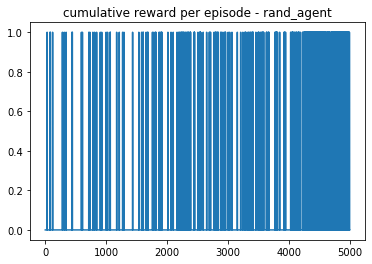

In [17]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [18]:
sarsa_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

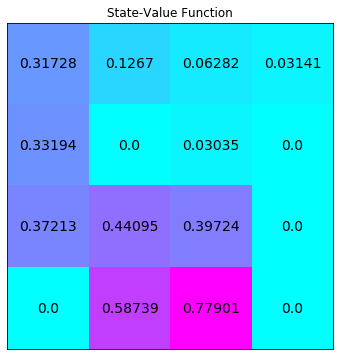

In [19]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [20]:
V.sum()

3.4771981271740833

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [21]:
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 1.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 1.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 284 - cum reward 0.0
episode: 285 - cum reward 0.0
episode: 286 - cum reward 0.0
episode: 287 - cum reward 0.0
episode: 288 - cum reward 0.0
episode: 289 - cum reward 1.0
episode: 290 - cum reward 0.0
episode: 291 - cum reward 0.0
episode: 292 - cum reward 0.0
episode: 293 - cum reward 0.0
episode: 294 - cum reward 0.0
episode: 295 - cum reward 1.0
episode: 296 - cum reward 0.0
episode: 297 - cum reward 0.0
episode: 298 - cum reward 0.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 1.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 1.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 1.0
episode: 314 - cum reward 1.0
episode: 315 - cum reward 1.0
episode: 316 - cum reward 0.0
episode: 3

episode: 561 - cum reward 0.0
episode: 562 - cum reward 1.0
episode: 563 - cum reward 1.0
episode: 564 - cum reward 0.0
episode: 565 - cum reward 0.0
episode: 566 - cum reward 0.0
episode: 567 - cum reward 1.0
episode: 568 - cum reward 0.0
episode: 569 - cum reward 1.0
episode: 570 - cum reward 0.0
episode: 571 - cum reward 1.0
episode: 572 - cum reward 1.0
episode: 573 - cum reward 0.0
episode: 574 - cum reward 0.0
episode: 575 - cum reward 1.0
episode: 576 - cum reward 0.0
episode: 577 - cum reward 0.0
episode: 578 - cum reward 0.0
episode: 579 - cum reward 0.0
episode: 580 - cum reward 0.0
episode: 581 - cum reward 1.0
episode: 582 - cum reward 1.0
episode: 583 - cum reward 1.0
episode: 584 - cum reward 0.0
episode: 585 - cum reward 1.0
episode: 586 - cum reward 0.0
episode: 587 - cum reward 1.0
episode: 588 - cum reward 0.0
episode: 589 - cum reward 0.0
episode: 590 - cum reward 1.0
episode: 591 - cum reward 0.0
episode: 592 - cum reward 1.0
episode: 593 - cum reward 0.0
episode: 5

episode: 845 - cum reward 1.0
episode: 846 - cum reward 0.0
episode: 847 - cum reward 1.0
episode: 848 - cum reward 0.0
episode: 849 - cum reward 0.0
episode: 850 - cum reward 0.0
episode: 851 - cum reward 0.0
episode: 852 - cum reward 0.0
episode: 853 - cum reward 0.0
episode: 854 - cum reward 0.0
episode: 855 - cum reward 0.0
episode: 856 - cum reward 0.0
episode: 857 - cum reward 0.0
episode: 858 - cum reward 0.0
episode: 859 - cum reward 1.0
episode: 860 - cum reward 1.0
episode: 861 - cum reward 0.0
episode: 862 - cum reward 0.0
episode: 863 - cum reward 1.0
episode: 864 - cum reward 1.0
episode: 865 - cum reward 1.0
episode: 866 - cum reward 0.0
episode: 867 - cum reward 1.0
episode: 868 - cum reward 1.0
episode: 869 - cum reward 1.0
episode: 870 - cum reward 1.0
episode: 871 - cum reward 0.0
episode: 872 - cum reward 0.0
episode: 873 - cum reward 0.0
episode: 874 - cum reward 1.0
episode: 875 - cum reward 1.0
episode: 876 - cum reward 1.0
episode: 877 - cum reward 1.0
episode: 8

episode: 1125 - cum reward 0.0
episode: 1126 - cum reward 0.0
episode: 1127 - cum reward 0.0
episode: 1128 - cum reward 1.0
episode: 1129 - cum reward 0.0
episode: 1130 - cum reward 1.0
episode: 1131 - cum reward 0.0
episode: 1132 - cum reward 1.0
episode: 1133 - cum reward 0.0
episode: 1134 - cum reward 0.0
episode: 1135 - cum reward 1.0
episode: 1136 - cum reward 0.0
episode: 1137 - cum reward 1.0
episode: 1138 - cum reward 0.0
episode: 1139 - cum reward 0.0
episode: 1140 - cum reward 0.0
episode: 1141 - cum reward 1.0
episode: 1142 - cum reward 0.0
episode: 1143 - cum reward 1.0
episode: 1144 - cum reward 0.0
episode: 1145 - cum reward 0.0
episode: 1146 - cum reward 1.0
episode: 1147 - cum reward 0.0
episode: 1148 - cum reward 0.0
episode: 1149 - cum reward 1.0
episode: 1150 - cum reward 1.0
episode: 1151 - cum reward 1.0
episode: 1152 - cum reward 0.0
episode: 1153 - cum reward 1.0
episode: 1154 - cum reward 0.0
episode: 1155 - cum reward 0.0
episode: 1156 - cum reward 1.0
episode:

episode: 1407 - cum reward 1.0
episode: 1408 - cum reward 0.0
episode: 1409 - cum reward 0.0
episode: 1410 - cum reward 0.0
episode: 1411 - cum reward 0.0
episode: 1412 - cum reward 0.0
episode: 1413 - cum reward 0.0
episode: 1414 - cum reward 1.0
episode: 1415 - cum reward 0.0
episode: 1416 - cum reward 0.0
episode: 1417 - cum reward 0.0
episode: 1418 - cum reward 1.0
episode: 1419 - cum reward 1.0
episode: 1420 - cum reward 1.0
episode: 1421 - cum reward 1.0
episode: 1422 - cum reward 1.0
episode: 1423 - cum reward 1.0
episode: 1424 - cum reward 1.0
episode: 1425 - cum reward 0.0
episode: 1426 - cum reward 1.0
episode: 1427 - cum reward 1.0
episode: 1428 - cum reward 0.0
episode: 1429 - cum reward 0.0
episode: 1430 - cum reward 1.0
episode: 1431 - cum reward 1.0
episode: 1432 - cum reward 0.0
episode: 1433 - cum reward 1.0
episode: 1434 - cum reward 0.0
episode: 1435 - cum reward 0.0
episode: 1436 - cum reward 0.0
episode: 1437 - cum reward 1.0
episode: 1438 - cum reward 1.0
episode:

episode: 1696 - cum reward 1.0
episode: 1697 - cum reward 1.0
episode: 1698 - cum reward 0.0
episode: 1699 - cum reward 0.0
episode: 1700 - cum reward 1.0
episode: 1701 - cum reward 0.0
episode: 1702 - cum reward 0.0
episode: 1703 - cum reward 1.0
episode: 1704 - cum reward 1.0
episode: 1705 - cum reward 1.0
episode: 1706 - cum reward 1.0
episode: 1707 - cum reward 0.0
episode: 1708 - cum reward 0.0
episode: 1709 - cum reward 0.0
episode: 1710 - cum reward 1.0
episode: 1711 - cum reward 1.0
episode: 1712 - cum reward 0.0
episode: 1713 - cum reward 0.0
episode: 1714 - cum reward 1.0
episode: 1715 - cum reward 0.0
episode: 1716 - cum reward 0.0
episode: 1717 - cum reward 0.0
episode: 1718 - cum reward 0.0
episode: 1719 - cum reward 0.0
episode: 1720 - cum reward 1.0
episode: 1721 - cum reward 0.0
episode: 1722 - cum reward 1.0
episode: 1723 - cum reward 0.0
episode: 1724 - cum reward 1.0
episode: 1725 - cum reward 0.0
episode: 1726 - cum reward 0.0
episode: 1727 - cum reward 0.0
episode:

episode: 1987 - cum reward 1.0
episode: 1988 - cum reward 0.0
episode: 1989 - cum reward 0.0
episode: 1990 - cum reward 1.0
episode: 1991 - cum reward 1.0
episode: 1992 - cum reward 1.0
episode: 1993 - cum reward 1.0
episode: 1994 - cum reward 1.0
episode: 1995 - cum reward 0.0
episode: 1996 - cum reward 0.0
episode: 1997 - cum reward 0.0
episode: 1998 - cum reward 0.0
episode: 1999 - cum reward 0.0
episode: 2000 - cum reward 0.0
episode: 2001 - cum reward 0.0
episode: 2002 - cum reward 1.0
episode: 2003 - cum reward 0.0
episode: 2004 - cum reward 0.0
episode: 2005 - cum reward 0.0
episode: 2006 - cum reward 1.0
episode: 2007 - cum reward 1.0
episode: 2008 - cum reward 1.0
episode: 2009 - cum reward 1.0
episode: 2010 - cum reward 1.0
episode: 2011 - cum reward 1.0
episode: 2012 - cum reward 1.0
episode: 2013 - cum reward 1.0
episode: 2014 - cum reward 1.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 1.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 0.0
episode:

episode: 2272 - cum reward 0.0
episode: 2273 - cum reward 0.0
episode: 2274 - cum reward 0.0
episode: 2275 - cum reward 1.0
episode: 2276 - cum reward 1.0
episode: 2277 - cum reward 0.0
episode: 2278 - cum reward 0.0
episode: 2279 - cum reward 0.0
episode: 2280 - cum reward 0.0
episode: 2281 - cum reward 1.0
episode: 2282 - cum reward 0.0
episode: 2283 - cum reward 1.0
episode: 2284 - cum reward 1.0
episode: 2285 - cum reward 0.0
episode: 2286 - cum reward 0.0
episode: 2287 - cum reward 1.0
episode: 2288 - cum reward 0.0
episode: 2289 - cum reward 1.0
episode: 2290 - cum reward 0.0
episode: 2291 - cum reward 1.0
episode: 2292 - cum reward 0.0
episode: 2293 - cum reward 1.0
episode: 2294 - cum reward 1.0
episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 1.0
episode: 2297 - cum reward 1.0
episode: 2298 - cum reward 1.0
episode: 2299 - cum reward 1.0
episode: 2300 - cum reward 1.0
episode: 2301 - cum reward 1.0
episode: 2302 - cum reward 1.0
episode: 2303 - cum reward 0.0
episode:

episode: 2553 - cum reward 1.0
episode: 2554 - cum reward 1.0
episode: 2555 - cum reward 0.0
episode: 2556 - cum reward 1.0
episode: 2557 - cum reward 0.0
episode: 2558 - cum reward 0.0
episode: 2559 - cum reward 0.0
episode: 2560 - cum reward 1.0
episode: 2561 - cum reward 0.0
episode: 2562 - cum reward 0.0
episode: 2563 - cum reward 1.0
episode: 2564 - cum reward 0.0
episode: 2565 - cum reward 0.0
episode: 2566 - cum reward 1.0
episode: 2567 - cum reward 0.0
episode: 2568 - cum reward 1.0
episode: 2569 - cum reward 0.0
episode: 2570 - cum reward 0.0
episode: 2571 - cum reward 1.0
episode: 2572 - cum reward 1.0
episode: 2573 - cum reward 0.0
episode: 2574 - cum reward 1.0
episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 0.0
episode: 2578 - cum reward 0.0
episode: 2579 - cum reward 0.0
episode: 2580 - cum reward 0.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 1.0
episode: 2583 - cum reward 0.0
episode: 2584 - cum reward 1.0
episode:

episode: 2825 - cum reward 0.0
episode: 2826 - cum reward 0.0
episode: 2827 - cum reward 0.0
episode: 2828 - cum reward 0.0
episode: 2829 - cum reward 0.0
episode: 2830 - cum reward 0.0
episode: 2831 - cum reward 0.0
episode: 2832 - cum reward 1.0
episode: 2833 - cum reward 0.0
episode: 2834 - cum reward 0.0
episode: 2835 - cum reward 1.0
episode: 2836 - cum reward 1.0
episode: 2837 - cum reward 0.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 1.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 1.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 0.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 0.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode: 2854 - cum reward 0.0
episode: 2855 - cum reward 1.0
episode: 2856 - cum reward 0.0
episode:

episode: 3094 - cum reward 0.0
episode: 3095 - cum reward 0.0
episode: 3096 - cum reward 1.0
episode: 3097 - cum reward 1.0
episode: 3098 - cum reward 0.0
episode: 3099 - cum reward 1.0
episode: 3100 - cum reward 0.0
episode: 3101 - cum reward 0.0
episode: 3102 - cum reward 1.0
episode: 3103 - cum reward 1.0
episode: 3104 - cum reward 0.0
episode: 3105 - cum reward 1.0
episode: 3106 - cum reward 1.0
episode: 3107 - cum reward 0.0
episode: 3108 - cum reward 1.0
episode: 3109 - cum reward 1.0
episode: 3110 - cum reward 0.0
episode: 3111 - cum reward 0.0
episode: 3112 - cum reward 1.0
episode: 3113 - cum reward 1.0
episode: 3114 - cum reward 0.0
episode: 3115 - cum reward 0.0
episode: 3116 - cum reward 0.0
episode: 3117 - cum reward 1.0
episode: 3118 - cum reward 0.0
episode: 3119 - cum reward 0.0
episode: 3120 - cum reward 1.0
episode: 3121 - cum reward 0.0
episode: 3122 - cum reward 0.0
episode: 3123 - cum reward 0.0
episode: 3124 - cum reward 1.0
episode: 3125 - cum reward 0.0
episode:

episode: 3368 - cum reward 1.0
episode: 3369 - cum reward 0.0
episode: 3370 - cum reward 0.0
episode: 3371 - cum reward 0.0
episode: 3372 - cum reward 1.0
episode: 3373 - cum reward 0.0
episode: 3374 - cum reward 1.0
episode: 3375 - cum reward 0.0
episode: 3376 - cum reward 0.0
episode: 3377 - cum reward 1.0
episode: 3378 - cum reward 0.0
episode: 3379 - cum reward 1.0
episode: 3380 - cum reward 0.0
episode: 3381 - cum reward 0.0
episode: 3382 - cum reward 1.0
episode: 3383 - cum reward 0.0
episode: 3384 - cum reward 0.0
episode: 3385 - cum reward 0.0
episode: 3386 - cum reward 1.0
episode: 3387 - cum reward 0.0
episode: 3388 - cum reward 1.0
episode: 3389 - cum reward 0.0
episode: 3390 - cum reward 0.0
episode: 3391 - cum reward 0.0
episode: 3392 - cum reward 0.0
episode: 3393 - cum reward 0.0
episode: 3394 - cum reward 0.0
episode: 3395 - cum reward 1.0
episode: 3396 - cum reward 0.0
episode: 3397 - cum reward 1.0
episode: 3398 - cum reward 1.0
episode: 3399 - cum reward 0.0
episode:

episode: 3638 - cum reward 0.0
episode: 3639 - cum reward 0.0
episode: 3640 - cum reward 0.0
episode: 3641 - cum reward 0.0
episode: 3642 - cum reward 1.0
episode: 3643 - cum reward 1.0
episode: 3644 - cum reward 1.0
episode: 3645 - cum reward 0.0
episode: 3646 - cum reward 0.0
episode: 3647 - cum reward 1.0
episode: 3648 - cum reward 0.0
episode: 3649 - cum reward 0.0
episode: 3650 - cum reward 0.0
episode: 3651 - cum reward 1.0
episode: 3652 - cum reward 0.0
episode: 3653 - cum reward 1.0
episode: 3654 - cum reward 1.0
episode: 3655 - cum reward 1.0
episode: 3656 - cum reward 1.0
episode: 3657 - cum reward 0.0
episode: 3658 - cum reward 0.0
episode: 3659 - cum reward 1.0
episode: 3660 - cum reward 0.0
episode: 3661 - cum reward 0.0
episode: 3662 - cum reward 0.0
episode: 3663 - cum reward 0.0
episode: 3664 - cum reward 1.0
episode: 3665 - cum reward 1.0
episode: 3666 - cum reward 0.0
episode: 3667 - cum reward 0.0
episode: 3668 - cum reward 1.0
episode: 3669 - cum reward 0.0
episode:

episode: 3904 - cum reward 1.0
episode: 3905 - cum reward 0.0
episode: 3906 - cum reward 0.0
episode: 3907 - cum reward 0.0
episode: 3908 - cum reward 0.0
episode: 3909 - cum reward 0.0
episode: 3910 - cum reward 1.0
episode: 3911 - cum reward 0.0
episode: 3912 - cum reward 1.0
episode: 3913 - cum reward 1.0
episode: 3914 - cum reward 1.0
episode: 3915 - cum reward 0.0
episode: 3916 - cum reward 0.0
episode: 3917 - cum reward 0.0
episode: 3918 - cum reward 1.0
episode: 3919 - cum reward 0.0
episode: 3920 - cum reward 0.0
episode: 3921 - cum reward 0.0
episode: 3922 - cum reward 0.0
episode: 3923 - cum reward 1.0
episode: 3924 - cum reward 0.0
episode: 3925 - cum reward 0.0
episode: 3926 - cum reward 0.0
episode: 3927 - cum reward 0.0
episode: 3928 - cum reward 0.0
episode: 3929 - cum reward 1.0
episode: 3930 - cum reward 1.0
episode: 3931 - cum reward 1.0
episode: 3932 - cum reward 1.0
episode: 3933 - cum reward 0.0
episode: 3934 - cum reward 0.0
episode: 3935 - cum reward 0.0
episode:

episode: 4193 - cum reward 0.0
episode: 4194 - cum reward 0.0
episode: 4195 - cum reward 1.0
episode: 4196 - cum reward 0.0
episode: 4197 - cum reward 0.0
episode: 4198 - cum reward 1.0
episode: 4199 - cum reward 1.0
episode: 4200 - cum reward 0.0
episode: 4201 - cum reward 0.0
episode: 4202 - cum reward 0.0
episode: 4203 - cum reward 0.0
episode: 4204 - cum reward 0.0
episode: 4205 - cum reward 0.0
episode: 4206 - cum reward 1.0
episode: 4207 - cum reward 1.0
episode: 4208 - cum reward 0.0
episode: 4209 - cum reward 0.0
episode: 4210 - cum reward 0.0
episode: 4211 - cum reward 1.0
episode: 4212 - cum reward 0.0
episode: 4213 - cum reward 0.0
episode: 4214 - cum reward 1.0
episode: 4215 - cum reward 0.0
episode: 4216 - cum reward 0.0
episode: 4217 - cum reward 0.0
episode: 4218 - cum reward 1.0
episode: 4219 - cum reward 1.0
episode: 4220 - cum reward 0.0
episode: 4221 - cum reward 0.0
episode: 4222 - cum reward 0.0
episode: 4223 - cum reward 0.0
episode: 4224 - cum reward 0.0
episode:

episode: 4473 - cum reward 0.0
episode: 4474 - cum reward 0.0
episode: 4475 - cum reward 1.0
episode: 4476 - cum reward 1.0
episode: 4477 - cum reward 0.0
episode: 4478 - cum reward 1.0
episode: 4479 - cum reward 0.0
episode: 4480 - cum reward 0.0
episode: 4481 - cum reward 1.0
episode: 4482 - cum reward 1.0
episode: 4483 - cum reward 1.0
episode: 4484 - cum reward 1.0
episode: 4485 - cum reward 0.0
episode: 4486 - cum reward 0.0
episode: 4487 - cum reward 1.0
episode: 4488 - cum reward 0.0
episode: 4489 - cum reward 0.0
episode: 4490 - cum reward 1.0
episode: 4491 - cum reward 0.0
episode: 4492 - cum reward 0.0
episode: 4493 - cum reward 1.0
episode: 4494 - cum reward 0.0
episode: 4495 - cum reward 1.0
episode: 4496 - cum reward 1.0
episode: 4497 - cum reward 0.0
episode: 4498 - cum reward 1.0
episode: 4499 - cum reward 0.0
episode: 4500 - cum reward 1.0
episode: 4501 - cum reward 0.0
episode: 4502 - cum reward 1.0
episode: 4503 - cum reward 0.0
episode: 4504 - cum reward 1.0
episode:

episode: 4741 - cum reward 1.0
episode: 4742 - cum reward 1.0
episode: 4743 - cum reward 0.0
episode: 4744 - cum reward 1.0
episode: 4745 - cum reward 1.0
episode: 4746 - cum reward 1.0
episode: 4747 - cum reward 0.0
episode: 4748 - cum reward 1.0
episode: 4749 - cum reward 0.0
episode: 4750 - cum reward 1.0
episode: 4751 - cum reward 0.0
episode: 4752 - cum reward 0.0
episode: 4753 - cum reward 0.0
episode: 4754 - cum reward 1.0
episode: 4755 - cum reward 0.0
episode: 4756 - cum reward 1.0
episode: 4757 - cum reward 0.0
episode: 4758 - cum reward 0.0
episode: 4759 - cum reward 1.0
episode: 4760 - cum reward 0.0
episode: 4761 - cum reward 0.0
episode: 4762 - cum reward 0.0
episode: 4763 - cum reward 0.0
episode: 4764 - cum reward 1.0
episode: 4765 - cum reward 0.0
episode: 4766 - cum reward 0.0
episode: 4767 - cum reward 0.0
episode: 4768 - cum reward 0.0
episode: 4769 - cum reward 0.0
episode: 4770 - cum reward 1.0
episode: 4771 - cum reward 1.0
episode: 4772 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

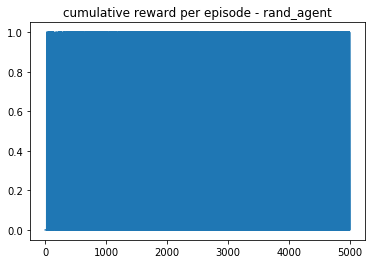

In [22]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [23]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

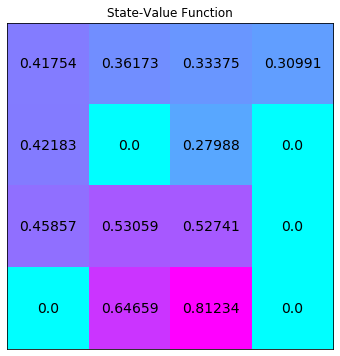

In [24]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [25]:
V.sum()

5.100116629064201

In [26]:
# Question: Why we don't have the optimal policy?

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}